In [1]:
!nvidia-smi

Sun Jan  5 15:23:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.58.02              Driver Version: 555.58.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    Off |   00000000:01:00.0  On |                  N/A |
|  0%   42C    P5             27W /  295W |     864MiB /  16376MiB |      6%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install -q gdown inference-gpu supervision 


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip install -q git+https://github.com/roboflow/sports.git


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

## ball, players, goalkeeper, refrees detection

In [5]:
# from inference import get_model
# from google.colab import userdata

In [ ]:
from ultralytics import YOLO
player_detection_model = YOLO("../../../runs/detect/train/weights/best.pt")

/home/shan/proj/sports/examples/soccer/notebooks/venv/lib/python3.8/site-packages/ultralytics/nn/tasks.py:567: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.loa

In [7]:
from tqdm import tqdm
import supervision as sv

def extract_crops(source_video_path: str, player_id: int, stride: int):
    frame_generator = sv.get_video_frames_generator(source_video_path, stride=stride)

    crops = []
    for frame in tqdm(frame_generator, desc='collecting crops'):
        result = player_detection_model(frame, conf=0.7, verbose=False)
        detections = result[0].boxes.data
        detections = sv.Detections.from_ultralytics(result[0])
        detections = detections.with_nms(threshold=0.5, class_agnostic=True)
        detections = detections[detections.class_id == player_id]
        for xyxy in detections.xyxy:
            # shrink the crop size by 0.8
            w = xyxy[2] - xyxy[0]
            h = xyxy[3] - xyxy[1]
            xyxy[0] += w * 0.1
            xyxy[1] += h * 0.1
            xyxy[2] -= w * 0.1
            xyxy[3] -= h * 0.1
            crops.append(sv.crop_image(frame, xyxy))

    return crops

In [8]:
import numpy as np

def resolve_goalkeepers_team_id(
    players_detections: sv.Detections,
    goalkeepers_detections: sv.Detections
):
    goalkeepers_xy = goalkeepers_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    
    team_0_centroid = players_xy[players_detections.class_id == 0].mean(axis=0)
    team_1_centroid = players_xy[players_detections.class_id == 1].mean(axis=0)

    goalkeepers_team_ids = []
    for goalkeeper_xy in goalkeepers_xy:
        dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
        dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
        goalkeepers_team_ids.append(0 if dist_0 < dist_1 else 1)

    return np.array(goalkeepers_team_ids, dtype=np.int32)

In [9]:
from tqdm import tqdm
import torch
from sports.common.team import TeamClassifier

SOURCE_VIDEO_PATH = "../data/08fd33_0.mp4"
TARGET_VIDEO_PATH = "../data/08fd33_0_result_1.mp4"

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

STRIDE = 30


In [10]:
crops = extract_crops(SOURCE_VIDEO_PATH, player_id=PLAYER_ID, stride=STRIDE)
team_classifier = TeamClassifier(device=DEVICE)
team_classifier.fit(crops)

collecting crops: 25it [00:02, 12.24it/s]
Embedding extraction: 16it [00:01, 11.64it/s]


In [11]:
# len(crops)
# sv.plot_images_grid(crops[:100], grid_size=(10, 10))

In [12]:
# import torch
# from transformers import AutoProcessor, SiglipVisionModel

# SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'

# EMBEDDINGS_MODEL = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)
# EMBEDDINGS_PROCESSOR = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)


In [13]:
# import numpy as np
# from more_itertools import chunked

# BATCH_SIZE = 32

# pil_crops = [sv.cv2_to_pillow(crop) for crop in crops]
# batches = chunked(pil_crops, BATCH_SIZE)
# data = []

# with torch.no_grad():
#     for batch in tqdm(batches, desc='extracting embeddings'):
#         inputs = EMBEDDINGS_PROCESSOR(images=batch, return_tensors='pt').to(DEVICE)
#         outputs = EMBEDDINGS_MODEL(**inputs)
#         embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
#         data.append(embeddings)

# data = np.concatenate(data, axis=0)
# data.shape

In [14]:
# import umap
# from sklearn.cluster import KMeans

# REDUCER = umap.UMAP(n_components=3)
# CLUSTERING_MODEL = KMeans(n_clusters=2)

In [15]:
# projections = REDUCER.fit_transform(data)
# projections.shape

In [16]:
# clusters = CLUSTERING_MODEL.fit_predict(projections)
# clusters.shape

In [17]:
# clusters[:10]

In [18]:
# team_0 = [
#     crop
#     for crop, cluster
#     in zip(crops, clusters)
#     if cluster == 0
# ]
# sv.plot_images_grid(team_0[:100], grid_size=(10, 10))

## Pitch keypoint detection

## project pitch lines on frame

In [19]:
# from sports.configs.soccer import SoccerPitchConfiguration

# CONFIG = SoccerPitchConfiguration()
# CONFIG.vertices

In [20]:
# from sports.annotators.soccer import draw_pitch
# annotated_frame = draw_pitch(CONFIG)

# sv.plot_image(annotated_frame)

In [21]:
import cv2

class ViewTransformer:

    def __init__(self, source: np.ndarray, target: np.ndarray):
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m, _ = cv2.findHomography(source, target)

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        points = points.reshape(-1, 1, 2).astype(np.float32)
        points = cv2.perspectiveTransform(points, self.m)
        return points.reshape(-1, 2).astype(np.float32)

In [22]:
from sports.common.team import TeamClassifier
from sports.annotators.soccer import draw_pitch, draw_points_on_pitch, draw_pitch_voronoi_diagram
from sports.configs.soccer import SoccerPitchConfiguration

CONFIG = SoccerPitchConfiguration()
# CONFIG.vertices


In [ ]:
import numpy as np
from collections import deque
import cv2
from tqdm import tqdm
from typing import List, Union

# Initialize variables
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

STRIDE = 30

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)

label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.ColorPalette.from_hex(['#000000']),
    text_padding=5,
    text_position=sv.Position.BOTTOM_CENTER,
)

triangle_annotator = sv.TriangleAnnotator(
    color=sv.ColorPalette.from_hex(['#FFD700']),
    base=20, height=17
)

dot_annotator = sv.DotAnnotator(
    color=sv.ColorPalette.from_hex(['#FFD700']),
    radius=5
)

pitch_detection_model = YOLO("../../../runs/pose/train/weights/best.pt")

# tracker = sv.ByteTrack()
# tracker.reset()

from deep_sort import nn_matching
from deep_sort.detection import Detection
from deep_sort.tracker import Tracker

max_cosine_distance = 0.2
metric = nn_matching.NearestNeighborDistanceMetric(
        "cosine", max_cosine_distance, None)
tracker = Tracker(metric=metric, max_iou_distance=0.9, max_age=30, n_init=3)

def tracker_update(tracker: Tracker, detections: sv.Detections, features: List[np.ndarray]) -> sv.Detections:
    detection_list = []
    assert len(detections) == len(features), "Number of detections and features should be the same."

    for i in range(len(detections)):
        xyxy = detections.xyxy[i]
        confidence = float(detections.confidence[i])
        feature = features[i].tolist()
        class_id = int(detections.class_id[i])

        tlwh = [xyxy[0], xyxy[1], xyxy[2] - xyxy[0], xyxy[3] - xyxy[1]]
        detection_list.append(Detection(tlwh, confidence, feature, class_id))

    tracker.predict()
    tracker.update(detection_list)

    xyxy = []
    confidence = []
    tracker_id = []
    class_id = []
    
    for track in tracker.tracks:
        if not track.is_confirmed() or track.time_since_update > 3:
            continue
        tlbr = track.to_tlbr()

        # clip the bounding box within the frame
        tlbr[0] = max(0, tlbr[0])
        tlbr[1] = max(0, tlbr[1])
        tlbr[2] = min(video_info.width-1, tlbr[2])
        tlbr[3] = min(video_info.height-1, tlbr[3])

        if tlbr[0] < 0 or tlbr[1] < 0 or tlbr[2] < 0 or tlbr[3] < 0 or \
            tlbr[0] > video_info.width or tlbr[1] > video_info.height or \
            tlbr[2] > video_info.width or tlbr[3] > video_info.height:
            print(f"Invalid bounding box: {tlbr}, skip.")
            continue

        xyxy.append(tlbr)
        confidence.append(track.confidence)
        tracker_id.append(track.track_id)
        class_id.append(track.class_id)

    output = sv.Detections(
        xyxy=np.array(xyxy).reshape(-1, 4),
        confidence=np.array(confidence),
        tracker_id=np.array(tracker_id),
        class_id=np.array(class_id)
    )
    
    return output

M = deque(maxlen=5)

processed_data = {
    "frames": [],
    "all_detections": [],
    "ball_detections": [],
    "frame_reference_keypoints": [],
    "transformer_to_pitch": [],
}

# Processing Loop
for frame_id, frame in enumerate(tqdm(frame_generator, total=video_info.total_frames)):
    # if frame_id >= 100:
    #     break

    results = player_detection_model(frame, conf=0.3, verbose=False)
    detections = sv.Detections.from_ultralytics(results[0])

    ball_detections = detections[detections.class_id == BALL_ID]
    all_detections = detections[detections.class_id != BALL_ID].with_nms(threshold=0.7, class_agnostic=True)
    # all_detections = tracker.update_with_detections(all_detections)

    # Deepsort tracking
    # all_crops = [sv.crop_image(frame, xyxy) for xyxy in all_detections.xyxy]
    # shrink the crop size by 0.8
    all_crops = []
    for xyxy in all_detections.xyxy:
        w = xyxy[2] - xyxy[0]
        h = xyxy[3] - xyxy[1]
        xyxy[0] += w * 0.1
        xyxy[1] += h * 0.1
        xyxy[2] -= w * 0.1
        xyxy[3] -= h * 0.1
        all_crops.append(sv.crop_image(frame, xyxy))
    all_features = team_classifier.extract_features(all_crops)
    all_detections = tracker_update(tracker, all_detections, all_features)

    goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
    players_detections = all_detections[all_detections.class_id == PLAYER_ID]
    referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

    # players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
    players_crops = []
    for xyxy in players_detections.xyxy:
        w = xyxy[2] - xyxy[0]
        h = xyxy[3] - xyxy[1]
        xyxy[0] += w * 0.1
        xyxy[1] += h * 0.1
        xyxy[2] -= w * 0.1
        xyxy[3] -= h * 0.1
        if xyxy[0] < 0 or xyxy[1] < 0 or xyxy[2] > video_info.width or xyxy[3] > video_info.height:
            print(f"Invalid bounding box: {xyxy}")
            xyxy[0] = max(0, xyxy[0])
            xyxy[1] = max(0, xyxy[1])
            xyxy[2] = min(video_info.width-1, xyxy[2])
            xyxy[3] = min(video_info.height-1, xyxy[3])
        players_crops.append(sv.crop_image(frame, xyxy))
    players_detections.class_id = team_classifier.predict(players_crops)
    goalkeepers_detections.class_id = resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)
    referees_detections.class_id -= 1

    players_detections = sv.Detections.merge([players_detections, goalkeepers_detections])

    all_detections = sv.Detections.merge([players_detections, referees_detections])

    keypoints = sv.KeyPoints.from_ultralytics(pitch_detection_model(frame, conf=0.0, verbose=False)[0])
    filter = keypoints.confidence[0] > 0.5
    frame_reference_points = keypoints.xy[0][filter]
    pitch_reference_points = np.array(CONFIG.vertices)[filter]

    frame_reference_keypoints = sv.KeyPoints(xy=frame_reference_points[np.newaxis, ...])
    
    transformer_to_pitch = ViewTransformer(
        source=frame_reference_points,
        target=pitch_reference_points
    )
    M.append(transformer_to_pitch.m)

    assert all(matrix.shape == M[0].shape for matrix in M), "Inconsistent matrix dimensions in M."
    transformer_to_pitch.m = np.mean(np.array(M), axis=0)

    # Store processed data
    processed_data["frames"].append(frame)
    processed_data["all_detections"].append(all_detections)
    processed_data["ball_detections"].append(ball_detections)
    processed_data["frame_reference_keypoints"].append(frame_reference_keypoints)
    processed_data["transformer_to_pitch"].append(transformer_to_pitch)

### Set one class_id for each track (Relies on tracking accuracy)
# # Convert all_detections from frame level to track level
# all_detections = processed_data["all_detections"]
# tracks = {}
# for frame_id in range(len(all_detections)):
#     for tracker_id, class_id in zip(all_detections[frame_id].tracker_id, all_detections[frame_id].class_id):
#         if tracker_id not in tracks:
#             tracks[tracker_id] = []
#         tracks[tracker_id].append((frame_id, class_id))

# # Find the optimal class_id for each player track
# track_class_ids = {}
# for tracker_id, track in tracks.items():
#     class_ids = [class_id for _, class_id in track]
#     class_id = max(set(class_ids), key=class_ids.count)
#     track_class_ids[tracker_id] = class_id

# # Update all_detections with the optimal class_id
# for frame_id, frame_detections in enumerate(all_detections):
#     tracker_ids = frame_detections.tracker_id
#     class_ids = frame_detections.class_id
#     for index, tracker_id in enumerate(tracker_ids):
#         class_ids[index] = track_class_ids[tracker_id]


Embedding extraction: 1it [00:00, 14.29it/s]
Embedding extraction: 1it [00:00, 14.57it/s]/s]
Embedding extraction: 1it [00:00, 14.62it/s]/s]
Embedding extraction: 1it [00:00, 17.27it/s]
Embedding extraction: 1it [00:00, 14.92it/s]/s]
Embedding extraction: 1it [00:00, 15.32it/s]
Embedding extraction: 1it [00:00, 14.41it/s]/s]
Embedding extraction: 1it [00:00, 15.03it/s]
Embedding extraction: 1it [00:00, 14.28it/s]/s]
Embedding extraction: 1it [00:00, 14.82it/s]
Embedding extraction: 1it [00:00, 14.83it/s]/s]
Embedding extraction: 1it [00:00, 15.67it/s]
Embedding extraction: 1it [00:00, 14.78it/s]/s]
Embedding extraction: 1it [00:00, 15.33it/s]
Embedding extraction: 1it [00:00, 14.74it/s]/s]
Embedding extraction: 1it [00:00, 15.08it/s]
Embedding extraction: 1it [00:00, 14.31it/s]/s]
Embedding extraction: 1it [00:00, 15.25it/s]
Embedding extraction: 1it [00:00, 15.01it/s]t/s]
Embedding extraction: 1it [00:00, 14.98it/s]
Embedding extraction: 1it [00:00, 14.95it/s]t/s]
Embedding extraction

Invalid bounding box: [          0      412.35    -0.23275      461.25], skip.


Embedding extraction: 1it [00:00, 11.64it/s]
Embedding extraction: 1it [00:00, 15.82it/s]it/s]
Embedding extraction: 1it [00:00, 11.69it/s]
Embedding extraction: 1it [00:00, 15.73it/s]it/s]
Embedding extraction: 1it [00:00, 12.27it/s]
Embedding extraction: 1it [00:00, 15.81it/s]it/s]
Embedding extraction: 1it [00:00, 11.72it/s]
Embedding extraction: 1it [00:00, 15.65it/s]it/s]
Embedding extraction: 1it [00:00, 11.69it/s]
Embedding extraction: 1it [00:00, 15.67it/s]it/s]
Embedding extraction: 1it [00:00, 11.66it/s]
Embedding extraction: 1it [00:00, 15.74it/s]it/s]
Embedding extraction: 1it [00:00, 11.55it/s]
Embedding extraction: 1it [00:00, 16.24it/s]it/s]
Embedding extraction: 1it [00:00,  9.37it/s]
Embedding extraction: 1it [00:00, 15.59it/s]it/s]
Embedding extraction: 1it [00:00,  9.71it/s]
Embedding extraction: 1it [00:00, 15.50it/s]it/s]
Embedding extraction: 1it [00:00, 11.77it/s]
Embedding extraction: 1it [00:00, 15.63it/s]it/s]
Embedding extraction: 1it [00:00, 11.51it/s]
Embed

In [24]:
# Convert all_detections from frame level to track level
all_detections = processed_data["all_detections"]
tracks = {}
for frame_id in range(len(all_detections)):
    for tracker_id, class_id in zip(all_detections[frame_id].tracker_id, all_detections[frame_id].class_id):
        if tracker_id not in tracks:
            tracks[tracker_id] = []
        tracks[tracker_id].append((frame_id, class_id))

# Smooth the class_id with majority voting within a window=30
for tracker_id, track in tracks.items():
    class_id_deque = deque(maxlen=30)
    for i in range(len(track)):
        frame_id, class_id = track[i]
        class_id_deque.append(class_id)
        class_id = max(set(class_id_deque), key=class_id_deque.count)
        track[i] = (frame_id, class_id)

# Set the updated class_id to all_detections using tracks
for frame_id, frame_detections in enumerate(all_detections):
    tracker_ids = frame_detections.tracker_id
    for index, tracker_id in enumerate(tracker_ids):
        new_class_id = [class_id for frame_id_, class_id in tracks[tracker_id] if frame_id_ == frame_id][0]
        processed_data["all_detections"][frame_id].class_id[index] = new_class_id

In [25]:
path_raw = []
path_conf = []
for frame_id in tqdm(range(len(processed_data["frames"]))):
        frame = processed_data["frames"][frame_id]
        ball_detections = processed_data["ball_detections"][frame_id]
        transformer_to_pitch = processed_data["transformer_to_pitch"][frame_id]
        
        frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_ball_xy = transformer_to_pitch.transform_points(frame_ball_xy) if frame_ball_xy.size > 0 else np.empty((0, 2), dtype=np.float32)
        path_raw.append(pitch_ball_xy)
        path_conf.append(ball_detections.confidence)

# path_raw


100%|██████████| 750/750 [00:00<00:00, 233155.05it/s]


In [26]:
# path = [
#         np.empty((0, 2), dtype=np.float32) if coordinates.shape[0] >= 2 else coordinates
#         for coordinates 
#         in path_raw
# ]

# select the one with higher confidence if there are multiple detections
path = [
        coordinates[np.argmax(confidence)] if coordinates.shape[0] >= 2 else coordinates
        for coordinates, confidence
        in zip(path_raw, path_conf)
]

path = [coordinates.flatten() for coordinates in path]
# path

In [27]:


def replace_outliers_based_on_distance(
        positions: List[np.ndarray],
        distance_threshold: float
) -> List[np.ndarray]:
    last_valid_position: Union[np.ndarray, None] = None
    cleaned_positions: List[np.ndarray] = []

    for position in positions:
        if len(position) == 0:
            cleaned_positions.append(position)
            continue

        if last_valid_position is None:
            last_valid_position = position
            cleaned_positions.append(position)
            continue

        distance = np.linalg.norm(position - last_valid_position)
        if distance > distance_threshold:
            cleaned_positions.append(np.array([], dtype=np.float64))
        else:
            last_valid_position = position
            cleaned_positions.append(position)

    return cleaned_positions

def replace_outliers_based_on_speed(
        positions: List[np.ndarray],
        speed_threshold: float,
        fps: float = 30.0
) -> List[np.ndarray]:
    last_valid_position: Union[np.ndarray, None] = None
    last_valid_frame_id: int = 0
    cleaned_positions: List[np.ndarray] = []

    for frame_id, position in enumerate(positions):
        if len(position) == 0:
            cleaned_positions.append(position)
            continue

        if last_valid_position is None:
            last_valid_position = position
            last_valid_frame_id = frame_id
            cleaned_positions.append(position)
            continue

        duration = (frame_id - last_valid_frame_id) / fps # frames to seconds
        distance = np.linalg.norm(position - last_valid_position) / 100.0 # cm to m
        speed = distance / duration # m/s
        if speed > speed_threshold:
            cleaned_positions.append(np.array([], dtype=np.float64))
        else:
            last_valid_position = position
            last_valid_frame_id = frame_id
            cleaned_positions.append(position)

    return cleaned_positions

In [ ]:
# MAX_DISTANCE_THRESHOLD = 1500
# cleaned_path = replace_outliers_based_on_distance(path, MAX_DISTANCE_THRESHOLD)

MAX_SPEED_THRESHOLD = 50 # m/s
cleaned_path = replace_outliers_based_on_speed(path, MAX_SPEED_THRESHOLD)

In [29]:
# Interpolate missing positions in cleaned_path
def interpolate_missing(data):
    """
    Interpolates missing values (empty arrays) in a list of 2D points.
    
    Args:
        data (list): A list of numpy arrays, each representing a 2D point or empty array.

    Returns:
        list: A list with missing values interpolated using linear interpolation.
    """
    # Convert to a 2D NumPy array where missing values are replaced with NaN
    data_array = np.array([d if d.size > 0 else [np.nan, np.nan] for d in data])
    
    # Separate x and y coordinates
    x = data_array[:, 0]
    y = data_array[:, 1]
    
    # Indices where values are not NaN
    valid_indices = ~np.isnan(x)
    
    # Interpolate missing x and y values
    x_interpolated = np.interp(np.arange(len(x)), np.flatnonzero(valid_indices), x[valid_indices])
    y_interpolated = np.interp(np.arange(len(y)), np.flatnonzero(valid_indices), y[valid_indices])
    
    # Combine interpolated x and y
    interpolated_data = np.column_stack((x_interpolated, y_interpolated))
    
    # Convert back to original format: empty arrays for missing, interpolated values for others
    result = [np.array([]) if np.isnan(row).any() else row for row in interpolated_data]
    
    return result


In [30]:
full_path = np.array(interpolate_missing(cleaned_path))

# calculate the velocity vector of the ball using numpy in a line
FPS = 30.0
velocity = np.diff(full_path, axis=0) * FPS


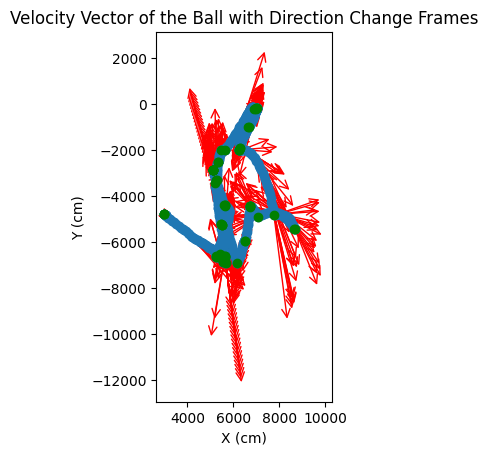

In [31]:
# Find the frames where the ball direction changes or stationary
def find_keyframes(velocity: np.ndarray, angle_threshold: float = 30, stationary_speed_threshold: float = 1.0) -> List[int]:
    """
    Finds the frames where the direction of the ball changes by at least a specified angle.

    Args:
        velocity (np.ndarray): A NumPy array of shape (N, 2) representing the velocity vector of the ball.
        angle_threshold (float): The angle threshold (in degrees) for detecting a direction change.

    Returns:
        List[int]: A list of frame indices where the direction of the ball changes significantly.
    """
    # Normalize velocity vectors to calculate angles
    norm_velocity = velocity / np.linalg.norm(velocity, axis=1, keepdims=True)
    
    # Calculate the dot product of consecutive velocity vectors
    dot_products = np.sum(norm_velocity[:-1] * norm_velocity[1:], axis=1)
    
    # Calculate the angle (in degrees) between consecutive velocity vectors
    angles = np.degrees(np.arccos(np.clip(dot_products, -1.0, 1.0)))
    
    # Find the indices where the angle exceeds the threshold OR the velocity is close to zero
    direction_changes_frames = np.where(angles >= angle_threshold)[0] + 1
    stationary_frames = np.where(np.linalg.norm(velocity, axis=1) < stationary_speed_threshold)[0]
    keyframes = np.unique(np.concatenate([direction_changes_frames, stationary_frames]))
    keyframes.sort()
    
    return keyframes

# Example usage
keyframes = find_keyframes(velocity, angle_threshold=60)

# plot the velocity vector with keyframes
def plot_velocity_vector_with_direction_change(velocity: np.ndarray, path: np.ndarray, keyframes: List[int]):
    import matplotlib.pyplot as plt
    from matplotlib.patches import FancyArrowPatch

    # inverse the y-axis
    path_plot = path.copy()
    velocity_plot = velocity.copy()
    path_plot[:, 1] *= -1
    velocity_plot[:, 1] *= -1
    fig, ax = plt.subplots()
    ax.plot(path_plot[:, 0], path_plot[:, 1], 'o', label='Path')
    for (x, y), (dx, dy) in zip(path_plot, velocity_plot):
        ax.add_patch(FancyArrowPatch((x, y), (x + dx, y + dy), color='red', arrowstyle='->', mutation_scale=15))
    
    for frame in keyframes:
        ax.plot(path_plot[frame, 0], path_plot[frame, 1], 'o', color='green', label='Direction Change')
    
    ax.set_aspect('equal')
    ax.set_xlabel('X (cm)')
    ax.set_ylabel('Y (cm)')
    ax.set_title('Velocity Vector of the Ball with Direction Change Frames')
    # ax.legend()
    plt.show()

plot_velocity_vector_with_direction_change(velocity, full_path, keyframes)

In [32]:
# Use the direction_change_frames as keyframes, and the rest as interpolated frames
def interpolate_path(path: np.ndarray, keyframes: List[int]) -> List[np.ndarray]:
    """
    Interpolates the path using keyframes.

    Args:
        path (np.ndarray): A NumPy array of shape (N, 2) representing the path of the ball.
        keyframes (List[int]): A list of frame indices to be used as keyframes.

    Returns:
        List[np.ndarray]: A list of interpolated paths.
    """
    interpolated_path = []
    total_frames = path.shape[0]

    keyframes = np.unique([0, *keyframes, total_frames - 1])

    # Interpolate for each segment between keyframes
    for i in range(len(keyframes) - 1):
        start_frame = keyframes[i]
        end_frame = keyframes[i + 1]
        start_position = path[start_frame]
        end_position = path[end_frame]
        interpolated_positions = np.linspace(
            start_position, end_position, end_frame - start_frame + 1
        )
        
        if i > 0:  # Avoid duplicate inclusion of keyframe
            interpolated_positions = interpolated_positions[1:]

        interpolated_path.extend(interpolated_positions)

    return interpolated_path

# Example usage
projected_path = interpolate_path(full_path, keyframes)

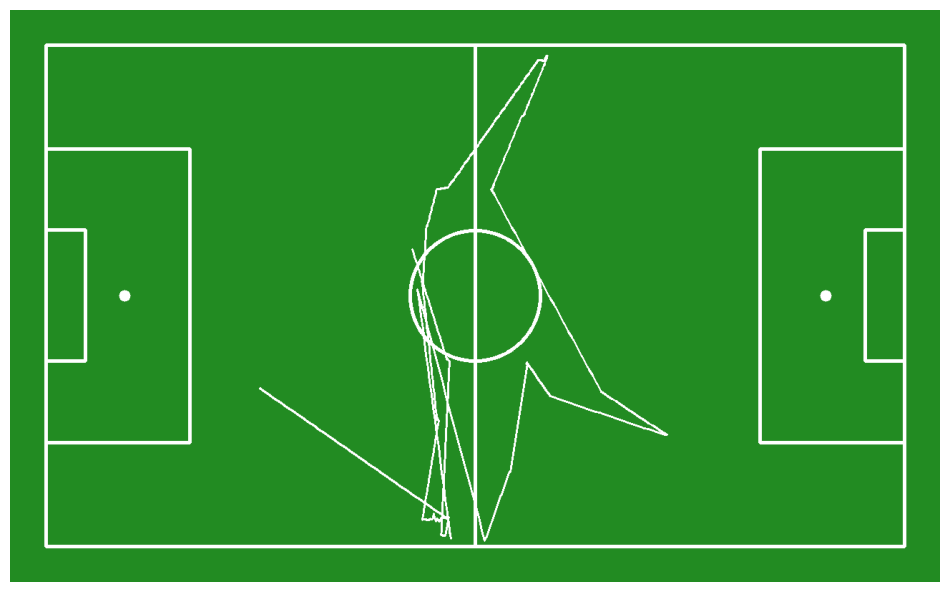

In [33]:
from sports.annotators.soccer import draw_paths_on_pitch

projected_path = [coordinates.flatten() for coordinates in projected_path]

annotated_frame = draw_pitch(config=CONFIG)
annotated_frame = draw_paths_on_pitch(
        config=CONFIG, 
        paths=[projected_path], 
        color=sv.Color.WHITE,
        pitch=annotated_frame
)

annotated_frame = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_ball_xy,
        face_color=sv.Color.WHITE,
        edge_color=sv.Color.BLACK,
        radius=10,
        pitch=annotated_frame
        )

sv.plot_image(annotated_frame)

In [34]:
dot_annotator = sv.DotAnnotator(
    color=sv.ColorPalette.from_hex(['#FFD700']),
    radius=5
)

# Rendering Loop
with video_sink:
    # idx = 0
    for frame_id in tqdm(range(len(processed_data["frames"])), desc="Rendering video"):
        # if idx >= 200:
        #     break
        # idx += 1

        frame = processed_data["frames"][frame_id]
        all_detections = processed_data["all_detections"][frame_id]
        ball_detections = processed_data["ball_detections"][frame_id]
        frame_reference_keypoints = processed_data["frame_reference_keypoints"][frame_id]
        transformer_to_pitch = processed_data["transformer_to_pitch"][frame_id]

        # Get players_detections and referees_detections
        players_detections = all_detections[all_detections.class_id != REFEREE_ID-1]
        referees_detections = all_detections[all_detections.class_id == REFEREE_ID-1]

        # Transform detections to pitch coordinates
        frame_players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_players_xy = transformer_to_pitch.transform_points(frame_players_xy) if frame_players_xy.size > 0 else np.full((1, 2), np.nan)
        frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_ball_xy = transformer_to_pitch.transform_points(frame_ball_xy) if frame_ball_xy.size > 0 else np.full((1, 2), np.nan)
        frame_referees_xy = referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_referees_xy = transformer_to_pitch.transform_points(frame_referees_xy) if frame_referees_xy.size > 0 else np.full((1, 2), np.nan)

        # # Transform pitch to frame coordinates
        # transformer_to_frame = transformer_to_pitch
        # transformer_to_frame.m = np.linalg.inv(transformer_to_pitch.m)
        # frame_all_points = transformer_to_frame.transform_points(np.array(CONFIG.vertices))
        # frame_all_keypoints = sv.KeyPoints(xy=frame_all_points[np.newaxis, ...])

        pitch = draw_pitch(config=CONFIG)

        if len(pitch_players_xy) > 0 and not np.isnan(pitch_players_xy).any():
            pitch = draw_pitch_voronoi_diagram(
                config=CONFIG,
                team_1_xy=pitch_players_xy[players_detections.class_id == 0],
                team_2_xy=pitch_players_xy[players_detections.class_id == 1],
                team_1_color=sv.Color.from_hex('#00BFFF'),
                team_2_color=sv.Color.from_hex('#FF1493'),
                pitch=pitch
            )
            
            pitch = draw_points_on_pitch(
                config=CONFIG,
                xy=pitch_players_xy[players_detections.class_id == 0],
                face_color=sv.Color.from_hex('#00BFFF'),
                edge_color=sv.Color.BLACK,
                radius=16,
                pitch=pitch
            )
            pitch = draw_points_on_pitch(
                config=CONFIG,
                xy=pitch_players_xy[players_detections.class_id == 1],
                face_color=sv.Color.from_hex('#FF1493'),
                edge_color=sv.Color.BLACK,
                radius=16,
                pitch=pitch
            )

        if len(pitch_referees_xy) > 0 and not np.isnan(pitch_referees_xy).any():
            pitch = draw_points_on_pitch(
                config=CONFIG,
                xy=pitch_referees_xy,
                face_color=sv.Color.from_hex('#FFD700'),
                edge_color=sv.Color.BLACK,
                radius=16,
                pitch=pitch
            )

        # if pitch_ball_xy.size > 0 and not np.isnan(pitch_ball_xy).any():
        #     pitch = draw_points_on_pitch(
        #         config=CONFIG,
        #         xy=pitch_ball_xy,
        #         face_color=sv.Color.WHITE,
        #         edge_color=sv.Color.BLACK,
        #         radius=10,
        #         pitch=pitch
        #     )

        pitch = draw_paths_on_pitch(
            config=CONFIG, 
            paths=[projected_path[max(0,frame_id-30):frame_id-1]], 
            color=sv.Color.WHITE,
            pitch=pitch
        )
        
        pitch = draw_points_on_pitch(
            config=CONFIG,
            xy=[projected_path[frame_id]],
            face_color=sv.Color.WHITE,
            edge_color=sv.Color.BLACK,
            radius=10,
            pitch=pitch
        )

        labels = [
            f"#{tracker_id}"
            for tracker_id
            in all_detections.tracker_id
        ]

        annotated_frame = frame.copy()
        # annotated_frame = edge_annotator.annotate(annotated_frame, frame_all_keypoints)
        # annotated_frame = vertex_annotator.annotate(annotated_frame, frame_reference_keypoints)

        annotated_frame = ellipse_annotator.annotate(annotated_frame, all_detections)
        annotated_frame = label_annotator.annotate(annotated_frame, all_detections, labels=labels)

        # Draw dot for ball_detections from past 5 frames
        for i in range(1, 6):
            if frame_id - i < 0:
                continue
            history_ball_detections = processed_data["ball_detections"][frame_id - i]
            if len(history_ball_detections) > 0:
                annotated_frame = dot_annotator.annotate(annotated_frame, history_ball_detections)
        annotated_frame = triangle_annotator.annotate(annotated_frame, ball_detections)

        scaled_pitch = cv2.resize(pitch, (frame.shape[1] // 2, frame.shape[0] // 2))
        scaled_pitch_height, scaled_pitch_width = scaled_pitch.shape[:2]
        frame_height, frame_width = frame.shape[:2]
        scaled_pitch_x = (frame_width - scaled_pitch_width) // 2
        scaled_pitch_y = frame_height - scaled_pitch_height
        overlay_frame = frame.copy()
        overlay_frame[scaled_pitch_y:scaled_pitch_y + scaled_pitch_height, scaled_pitch_x:scaled_pitch_x + scaled_pitch_width] = scaled_pitch
        annotated_frame = cv2.addWeighted(annotated_frame, 0.5, overlay_frame, 0.5, 0)
        
        video_sink.write_frame(annotated_frame)

Rendering video: 100%|██████████| 750/750 [01:25<00:00,  8.79it/s]
